# Evaluate planing quality

In [9]:
import pandas as pd
import numpy as np

import os
import re
import glob
import seaborn as sns

from utils import get_plans, fuse_plans, calculate_jaccard_score, make_pretty_plan_overlay

In [2]:
root = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Planning_user_study'
#root = r'E:\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'
#root = r'C:\Users\schnei17\Documents\PhD\Paper\Protonenradiografie\planning_study\Planning_user_study'

In [3]:
anonymize = False
save_figures = True

In [4]:
animals = os.listdir(root)
animals

['P1_H_B6_M52',
 'P1_H_B6_M57',
 'P1_H_B6_M61',
 'P1_H_C3H_M46',
 'P1_H_C3H_M48',
 'P1_H_C3H_M54',
 'P1_H_C3H_M58',
 'P2E_M11',
 'P2E_M14',
 'P2E_M2']

Let's first get an overview of all conducted plans and the respective observer:

In [5]:
plans = {'animal': [], 'observer': [], 'filenames': []}
for animal in animals:
    filenames = glob.glob(os.path.join(root, animal, '*.tif'))
    plans['animal'] += [animal] * len(filenames)
    plans['observer'] += [os.path.basename(f).split('_')[0] for f in filenames]
    plans['filenames'] += [os.path.basename(f) for f in filenames]

plans = pd.DataFrame(plans)

## Inter-observer variability

We first analyze inter-observer variability. For this, we remove occurrences of repeated plannings of animals by single users. More precisely, if an observer repeated the planning of the same animal multiple times, we keep only the results of the first run.

In [6]:
inter_observer = plans.drop_duplicates(subset = ['observer', 'animal'], keep='first')
inter_observer

,animal,observer,filenames
0,P1_H_B6_M52,JM,JM_220510_P1_H_B6_M52_Plan.tif
3,P1_H_B6_M52,MS,MS_P1_H_B6_M52_replanning.tif
4,P1_H_B6_M52,TS,TS_P1_H_B6_M52_Plan_2022-0505.tif
5,P1_H_B6_M57,JM,JM_220510_P1_H_B6_M57_Plan.tif
8,P1_H_B6_M57,MS,MS_P1_H_B6_M57_replanning.tif
9,P1_H_B6_M57,TS,TS_P1_H_B6_M57_Plan_2022-0505.tif
10,P1_H_B6_M61,JM,JM_P1_H_B6_M61_Plan_2022-05-24.tif
11,P1_H_B6_M61,MS,MS_P1_H_B6_M61_replanning.tif
12,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_2022-05-13.tif
15,P1_H_C3H_M46,JM,JM_220513_P1_H_B6_M46_Plan.tif


In [7]:
for animal in animals:
    _plans = inter_observer[inter_observer['animal'] == animal]
    plan_data = [get_plans(os.path.join(root, animal, f)) for f in _plans['filenames']]
    plan_data = np.stack(plan_data)
    
    plan_data_fused = fuse_plans(plan_data)
    jc = calculate_jaccard_score(plan_data, plan_data_fused)
    inter_observer.loc[inter_observer[inter_observer['animal'] == animal].index, jc.columns] = jc.to_numpy()
    #print(animal, jc.columns)

### Visualization and quantification

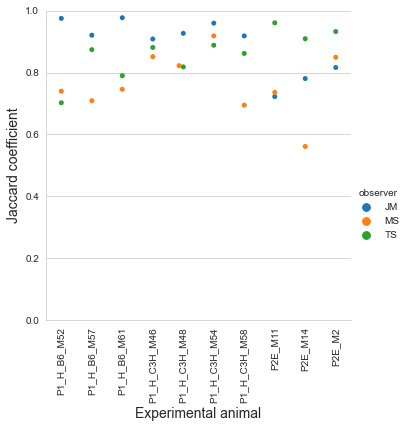

In [10]:
sns.set_style("whitegrid")
g = sns.catplot(data=inter_observer, x='animal', y='JC Label: 2', hue='observer', kind='swarm')
g.set_xticklabels(rotation=90)
g.set_xlabels('Experimental animal', fontsize=14)
g.set_ylabels('Jaccard coefficient', fontsize=14)
g.set(ylim=[0, 1])
g.savefig('./figures/Planning_interobserver_variability.png')

Let's calculate the global and animal-wise Jaccard coefficients. For global evaluation, we average the scores for each animal and the calculate the mean of all animal-wise averages. This is allowed since the sample-size for each animal is of the same size so that the results for each evaluation have the same weight.

In [11]:
mean = inter_observer['JC Label: 2'].mean()
std = inter_observer['JC Label: 2'].std()
print(f'Global mean Jaccard index: {mean} +/- {std}')

for animal in animals:
    sub = inter_observer[inter_observer['animal'] == animal]
    mean = sub['JC Label: 2'].mean()
    std = sub['JC Label: 2'].std()
    print(f'{animal} mean Jaccard index: {mean} +/- {std}')

Global mean Jaccard index: 0.838348566821174 +/- 0.10206565389254789
P1_H_B6_M52 mean Jaccard index: 0.8056438737299962 +/- 0.14780563697282653
P1_H_B6_M57 mean Jaccard index: 0.8345325230795702 +/- 0.11118357634184314
P1_H_B6_M61 mean Jaccard index: 0.8376042379647511 +/- 0.12279978388145475
P1_H_C3H_M46 mean Jaccard index: 0.8802456483435853 +/- 0.028583481509653286
P1_H_C3H_M48 mean Jaccard index: 0.8557735924742955 +/- 0.06147855760036852
P1_H_C3H_M54 mean Jaccard index: 0.9221359365236689 +/- 0.035877538100708116
P1_H_C3H_M58 mean Jaccard index: 0.8249135388827243 +/- 0.11634548013884173
P2E_M11 mean Jaccard index: 0.806342367369159 +/- 0.13388903869372165
P2E_M14 mean Jaccard index: 0.7502763528142243 +/- 0.17607890001269513
P2E_M2 mean Jaccard index: 0.8660175970297624 +/- 0.05980973714316945


## Intra-observer variability

We now analyze intra-observer variability.

In [14]:
intra_observer = plans[plans.duplicated(subset = ['observer', 'animal'], keep=False)]
intra_observer

,animal,observer,filenames
0,P1_H_B6_M52,JM,JM_220510_P1_H_B6_M52_Plan.tif
1,P1_H_B6_M52,JM,JM_220513_P1_H_B6_M52_Plan.tif
2,P1_H_B6_M52,JM,JM_220519_P1_H_B6_M52_Plan.tif
5,P1_H_B6_M57,JM,JM_220510_P1_H_B6_M57_Plan.tif
6,P1_H_B6_M57,JM,JM_220519_P1_H_B6_M57_Plan.tif
7,P1_H_B6_M57,JM,JM_220523_P1_H_B6_M57_Plan.tif
12,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_2022-05-13.tif
13,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_2022-0505.tif
14,P1_H_B6_M61,TS,TS_P1_H_B6_M61_Plan_TS_2022-05-16.tif
16,P1_H_C3H_M46,MS,MS_P1_H_C3H_M46_replanning.tif


In [15]:
for animal in animals:
    _plans = intra_observer[intra_observer['animal'] == animal]
    plan_data = [get_plans(os.path.join(root, animal, f)) for f in _plans['filenames']]
    plan_data = np.stack(plan_data)
    
    plan_data_fused = fuse_plans(plan_data)
    jc = calculate_jaccard_score(plan_data, plan_data_fused)
    intra_observer.loc[intra_observer[intra_observer['animal'] == animal].index, jc.columns] = jc.to_numpy()


### Visualization and quantification

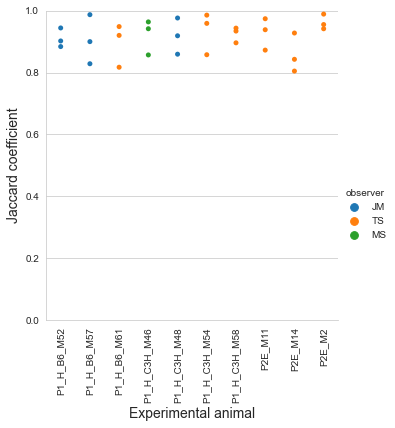

In [16]:
sns.set_style("whitegrid")
g = sns.catplot(data=intra_observer, x='animal', y='JC Label: 2', hue='observer', kind='swarm')
g.set_xticklabels(rotation=90)
g.set_xlabels('Experimental animal', fontsize=14)
g.set_ylabels('Jaccard coefficient', fontsize=14)
g.set(ylim=[0, 1])

In [17]:
mean = intra_observer['JC Label: 2'].mean()
std = intra_observer['JC Label: 2'].std()
print(f'Mean Jaccard index: {mean} +/- {std}')

Mean Jaccard index: 0.9156076666989403 +/- 0.05310499070147739
